# A sampler study

In this notebook, we perform a short study of how various samplers implemented in pyPESTO perform.

In [1]:
# install if not done yet
# !apt install libatlas-base-dev swig
# %pip install pypesto[amici,petab,pymc,emcee] --quiet

## The pipeline

First, we show a typical workflow, fully integrating the samplers with a [PEtab](https://github.com/petab-dev/petab) problem, using a toy example of a conversion reaction.

In [2]:
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml"
)
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

2022-09-06 23:57:02,916 - petab.lint - INFO - Checking model...
2022-09-06 23:57:02,917 - petab.lint - INFO - Checking measurement table...
2022-09-06 23:57:02,918 - petab.lint - INFO - Checking condition table...
2022-09-06 23:57:02,920 - petab.lint - INFO - Checking observable table...
2022-09-06 23:57:02,921 - petab.lint - INFO - Checking parameter table...
2022-09-06 23:57:02,927 - petab.lint - INFO - PEtab format check completed successfully.


Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [3]:
result = optimize.minimize(problem, n_starts=10, filename=None)

100%|█████████████████████████████████████████| 10/10 [00:01<00:00,  9.99it/s]


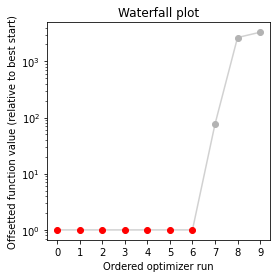

In [4]:
visualize.waterfall(result, size=(4, 4));

Next, we perform sampling. Here, we employ a `pypesto.sample.AdaptiveParallelTemperingSampler` sampler, which runs Markov Chain Monte Carlo (MCMC) chains on different temperatures. For each chain, we employ a `pypesto.sample.AdaptiveMetropolisSampler`. For more on the samplers see below or the API documentation.

In [5]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

For the actual sampling, we call the `pypesto.sample.sample` function. By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [6]:
%%time
result = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=result, filename=None
)

100%|██████████████████████████████████| 10000/10000 [00:26<00:00, 377.41it/s]
Elapsed time: 33.791418687000004
2022-09-06 23:57:30,836 - pypesto.sample.sample - INFO - Elapsed time: 33.791418687000004


CPU times: user 27.6 s, sys: 6.19 s, total: 33.8 s
Wall time: 26.5 s


When the sampling is finished, we can analyse our results. A first thing to do is to analyze the sampling burn-in:

In [7]:
sample.geweke_test(result)

Geweke burn-in index: 0
2022-09-06 23:57:30,912 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 0


0

pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

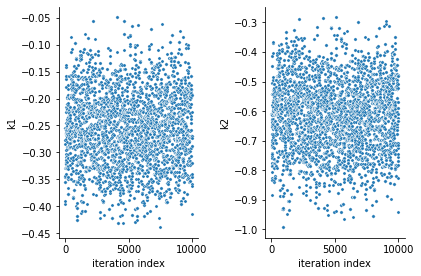

In [8]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False)

Next, also the log posterior trace can be visualized:

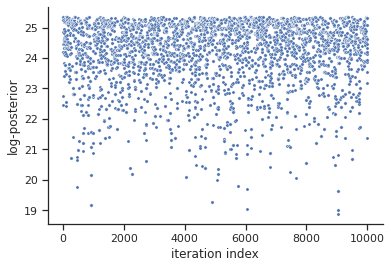

In [9]:
ax = visualize.sampling_fval_traces(result)

To visualize the result, there are various options. The scatter plot shows histograms of 1-dim parameter marginals and scatter plots of 2-dimensional parameter combinations:

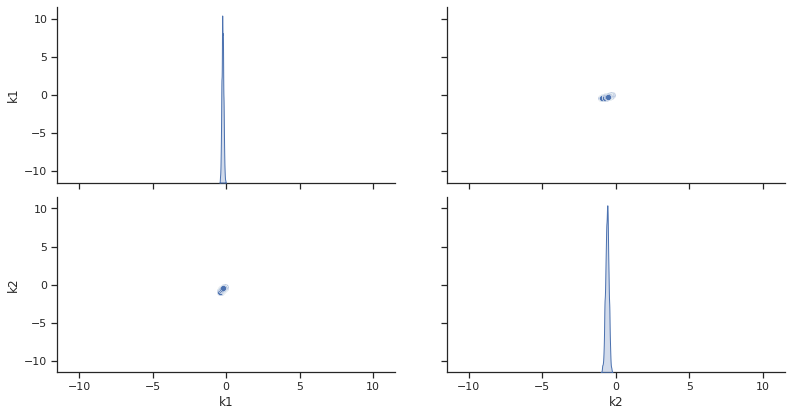

In [10]:
ax = visualize.sampling_scatter(result, size=[13, 6])

`sampling_1d_marginals` allows to plot e.g. kernel density estimates or histograms (internally using [seaborn](https://seaborn.pydata.org/)):

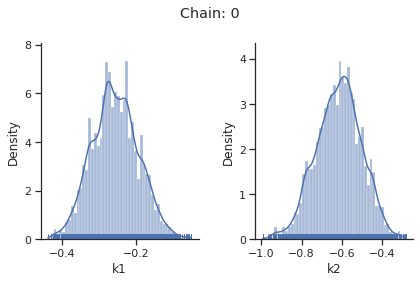

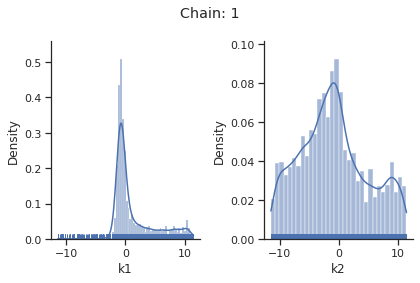

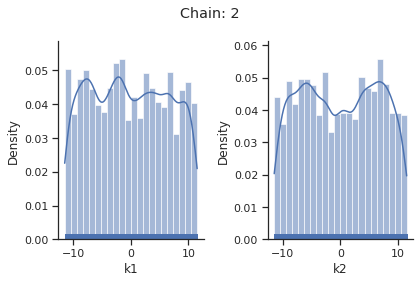

In [11]:
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )

That's it for the moment on using the sampling pipeline.

## 1-dim test problem

To compare and test the various implemented samplers, we first study a 1-dimensional test problem of a gaussian mixture density, together with a flat prior.

In [12]:
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal

import pypesto
import pypesto.sample as sample
import pypesto.visualize as visualize


def density(x):
    return 0.3 * multivariate_normal.pdf(
        x, mean=-1.5, cov=0.1
    ) + 0.7 * multivariate_normal.pdf(x, mean=2.5, cov=0.2)


def nllh(x):
    return -np.log(density(x))


objective = pypesto.Objective(fun=nllh)
problem = pypesto.Problem(objective=objective, lb=-4, ub=5, x_names=["x"])

The likelihood has two separate modes:

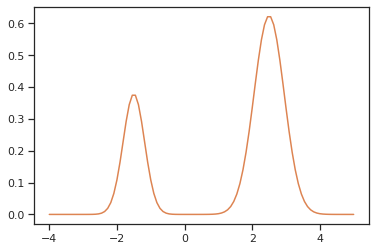

In [13]:
xs = np.linspace(-4, 5, 100)
ys = [density(x) for x in xs]

ax = sns.lineplot(x=xs, y=ys, color="C1")

### Metropolis sampler

For this problem, let us try out the simplest sampler, the `pypesto.sample.MetropolisSampler`.

In [14]:
sampler = sample.MetropolisSampler({"std": 0.5})
result = sample.sample(
    problem, 1e4, sampler, x0=np.array([0.5]), filename=None
)

100%|█████████████████████████████████| 10000/10000 [00:01<00:00, 5665.35it/s]
Elapsed time: 2.1371075249999976
2022-09-06 23:57:35,604 - pypesto.sample.sample - INFO - Elapsed time: 2.1371075249999976


Geweke burn-in index: 0
2022-09-06 23:57:35,644 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 0


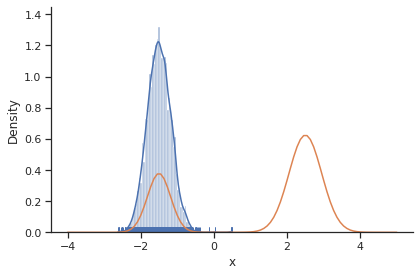

In [15]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

The obtained posterior does not accurately represent the distribution, often only capturing one mode. This is because it is hard for the Markov chain to jump between the distribution's two modes. This can be fixed by choosing a higher proposal variation `std`:

In [16]:
sampler = sample.MetropolisSampler({"std": 1})
result = sample.sample(
    problem, 1e4, sampler, x0=np.array([0.5]), filename=None
)

100%|█████████████████████████████████| 10000/10000 [00:01<00:00, 5723.94it/s]
Elapsed time: 1.9797902139999977
2022-09-06 23:57:37,744 - pypesto.sample.sample - INFO - Elapsed time: 1.9797902139999977


Geweke burn-in index: 1500
2022-09-06 23:57:37,779 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 1500


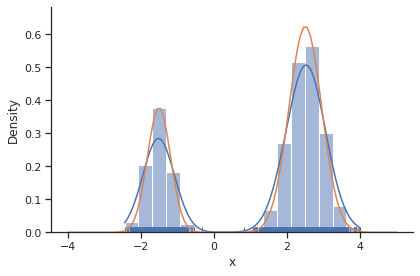

In [17]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

In general, MCMC have difficulties exploring multimodel landscapes. One way to overcome this is to used parallel tempering. There, various chains are run, lifting the densities to different temperatures. At high temperatures, proposed steps are more likely to get accepted and thus jumps between modes more likely.



### Parallel tempering sampler

In pyPESTO, the most basic parallel tempering algorithm is the `pypesto.sample.ParallelTemperingSampler`. It takes an `internal_sampler` parameter, to specify what sampler to use for performing sampling the different chains. Further, we can directly specify what inverse temperatures `betas` to use. When not specifying the `betas` explicitly but just the number of chains `n_chains`, an established near-exponential decay scheme is used.

In [18]:
sampler = sample.ParallelTemperingSampler(
    internal_sampler=sample.MetropolisSampler(), betas=[1, 1e-1, 1e-2]
)
result = sample.sample(
    problem, 1e4, sampler, x0=np.array([0.5]), filename=None
)

100%|█████████████████████████████████| 10000/10000 [00:05<00:00, 1680.27it/s]
Elapsed time: 6.619413623
2022-09-06 23:57:44,054 - pypesto.sample.sample - INFO - Elapsed time: 6.619413623


Geweke burn-in index: 500
2022-09-06 23:57:44,097 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 500


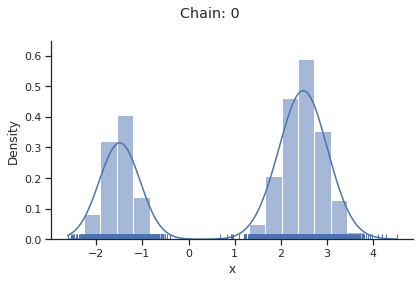

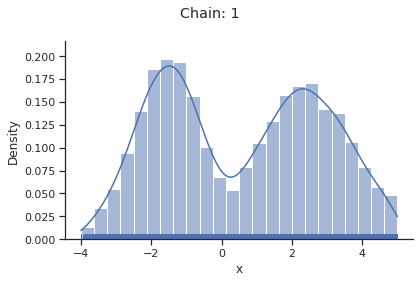

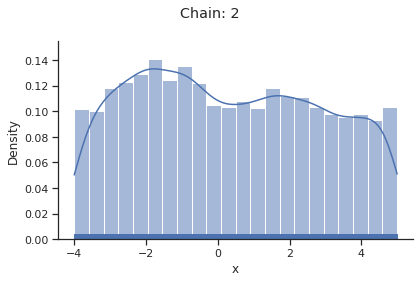

In [19]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )

Of interest is here finally the first chain at index `i_chain=0`, which approximates the posterior well.

### Adaptive Metropolis sampler

The problem of having to specify the proposal step variation manually can be overcome by using the `pypesto.sample.AdaptiveMetropolisSampler`, which iteratively adjusts the proposal steps to the function landscape.

In [20]:
sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(
    problem, 1e4, sampler, x0=np.array([0.5]), filename=None
)

100%|█████████████████████████████████| 10000/10000 [00:02<00:00, 4559.07it/s]
Elapsed time: 2.2116536799999977
2022-09-06 23:57:46,921 - pypesto.sample.sample - INFO - Elapsed time: 2.2116536799999977


Geweke burn-in index: 1000
2022-09-06 23:57:46,962 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 1000


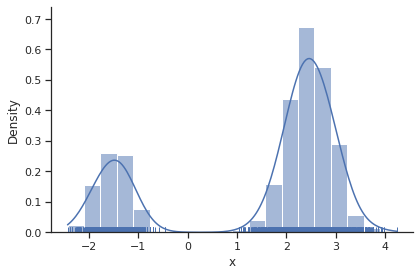

In [21]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)

### Adaptive parallel tempering sampler

The `pypesto.sample.AdaptiveParallelTemperingSampler` iteratively adjusts the temperatures to obtain good swapping rates between chains.

In [22]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)
result = sample.sample(
    problem, 1e4, sampler, x0=np.array([0.5]), filename=None
)

100%|█████████████████████████████████| 10000/10000 [00:07<00:00, 1407.55it/s]
Elapsed time: 7.328377719999992
2022-09-06 23:57:54,275 - pypesto.sample.sample - INFO - Elapsed time: 7.328377719999992


Geweke burn-in index: 500
2022-09-06 23:57:54,321 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 500


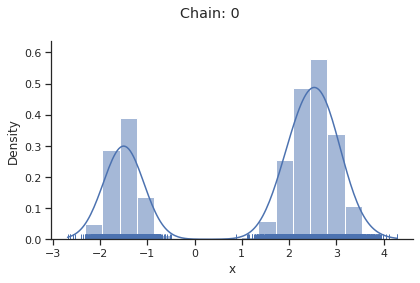

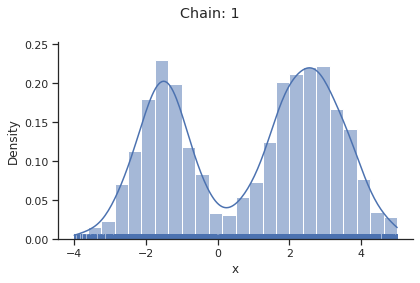

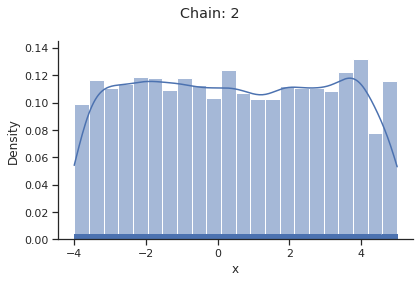

In [23]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )

In [24]:
result.sample_result.betas

array([1.00000000e+00, 2.34532365e-01, 2.00000000e-05])

### Pymc sampler

In [25]:
# from pypesto.sample.pymc import PymcSampler

# sampler = PymcSampler()
# result = sample.sample(
#     problem, 1e4, sampler, x0=np.array([0.5]), filename=None
# )

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
2022-09-06 23:57:57,198 - py.warnings - WARNING - /home/yannik/pypesto/pypesto/sample/pymc.py:154: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  data = pm.sample(

2022-09-06 23:57:57,534 - pymc - INFO - Auto-assigning NUTS sampler...
2022-09-06 23:57:57,535 - pymc - INFO - Initializing NUTS using jitter+adapt_diag...
2022-09-06 23:57:57,772 - pymc - INFO - Sequential sampling (1 chains in 1 job)
2022-09-06 23:57:57,773 - pymc - INFO - NUTS: [x]


2022-09-06 23:58:00,694 - pymc - INFO - Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 3 seconds.
Elapsed time: 3.6873787359999994
2022-09-06 23:58:00,865 - pypesto.sample.sample - INFO - Elapsed time: 3.6873787359999994


Geweke burn-in index: 1000
2022-09-06 23:58:00,900 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 1000


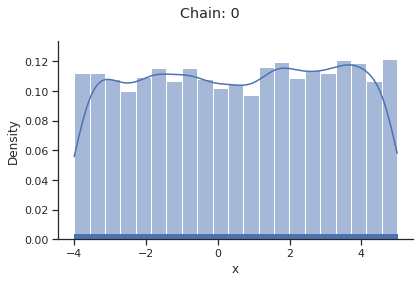

In [26]:
# sample.geweke_test(result)
# for i_chain in range(len(result.sample_result.betas)):
#     visualize.sampling_1d_marginals(
#         result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
#     )

If not specified, pymc chooses an adequate sampler automatically. 

### Emcee sampler

In [27]:
sampler = sample.EmceeSampler(nwalkers=10, run_args={"progress": True})
result = sample.sample(
    problem, int(1e4), sampler, x0=np.array([0.5]), filename=None
)

100%|██████████████████████████████████| 10000/10000 [00:16<00:00, 621.93it/s]
Elapsed time: 16.29948235799999
2022-09-06 23:58:17,281 - pypesto.sample.sample - INFO - Elapsed time: 16.29948235799999


Geweke burn-in index: 0
2022-09-06 23:58:17,804 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 0


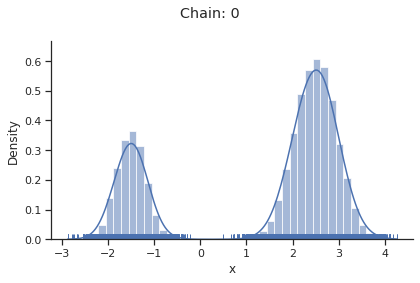

In [28]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )

## 2-dim test problem: Rosenbrock banana

The adaptive parallel tempering sampler with chains running adaptive Metropolis samplers is also able to sample from more challenging posterior distributions. To illustrates this shortly, we use the Rosenbrock function.

In [29]:
import scipy.optimize as so

import pypesto

# first type of objective
objective = pypesto.Objective(fun=so.rosen)

dim_full = 4
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

In [30]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=10
)
result = sample.sample(
    problem, 1e4, sampler, x0=np.zeros(dim_full), filename=None
)

100%|██████████████████████████████████| 10000/10000 [00:17<00:00, 557.31it/s]
Elapsed time: 17.98532136
2022-09-06 23:58:36,832 - pypesto.sample.sample - INFO - Elapsed time: 17.98532136


Geweke burn-in index: 4500
2022-09-06 23:58:36,983 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 4500


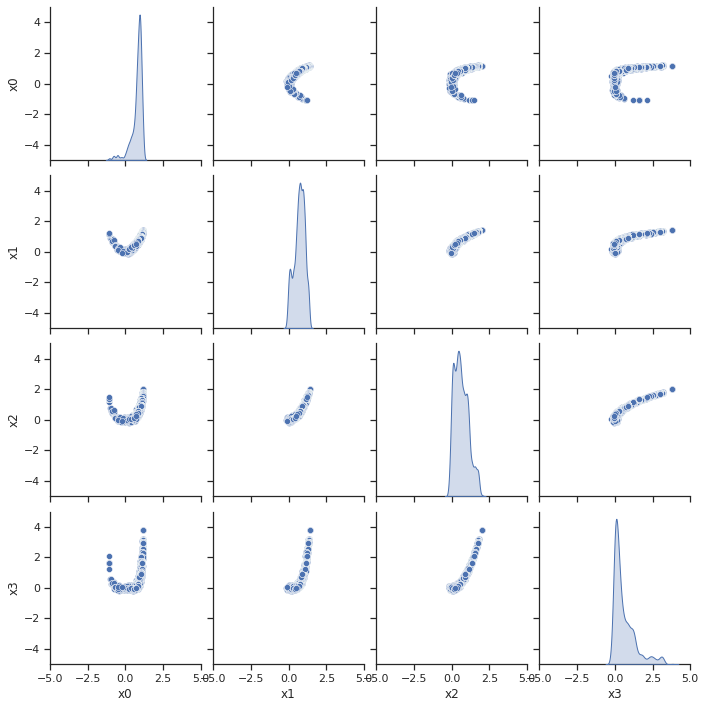

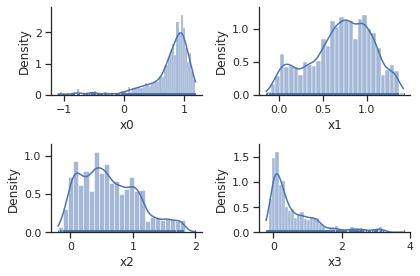

In [31]:
sample.geweke_test(result)
ax = visualize.sampling_scatter(result)
ax = visualize.sampling_1d_marginals(result)